### University Financial Health : Using Machine Learning to Revisit the Categorization of Colleges and Universities by S. Galloway
***

At the advent of the Covid-19 pandemic of 2020, Professor Scott Galloway proposed a classification system <a href="https://www.profgalloway.com/uss-university/">on his personal blog</a> by which colleges and universitites could be classified according to their financial health in an attempt to determine which schools would be adversely affected by the pandemic.

Collecting data on a set of 441 colleges and universities, Professor Galloway plotted schools on a two dimensional chart determined by their Value and Vulnerability.  The Value score was determined by three sub-scores that attempt to quantify credentials, experience and education of each school; each of these in turn depended on a handful of features from each school, which are represented in the dataset we have imported into this notebook.  The dataset as used by Galloway is posed through this Google Docs link <a href="https://docs.google.com/spreadsheets/d/1CUs3HrqstC2oV3CF3_di4yW6Y4K_CIrUJNEEHCCKo7A/edit#gid=0">here</a>.

While Professor Galloway's classification scheme inspired much online discussion as to the heath of hgiher education, his particular method of classifying schools drew criticism as being *ad hoc* (*c.f.*, <a href="https://universitybusiness.com/should-we-believe-scott-galloways-predictions-of-soon-to-perish-colleges/">this blog post</a>).

We will not attempt to resolve the question of how to classify schools according to their financial health here.  Instead, we will investigate whether, using the data made available by Galloway, his categorization scheme agrees with standard machine learning clustering algorithms.  By grouping the data in this way, we can provide a check to see whether Galloway's categories make sense.

After reducing to the raw data in Galloway's data set, we apply agglomerative clustering to the data to derive three clusters of data.  Upon comparing these clusters to Galloway's categories, we find that Galloway's categories predict different behaviors between clusters that show no significant differences under statistical testing.  We conclude that Galloway's categories do not provide an appropriate method to predict financial failures.

In [548]:
import pandas as pd
import scipy
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import ttest_ind, mannwhitneyu, kruskal, f_oneway
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
import re

filterwarnings("ignore", category = DeprecationWarning) 
filterwarnings("ignore", category = FutureWarning) 
filterwarnings("ignore", category = UserWarning)

plt.style.use('dark_background')

We copy the original data set and leave the original as read only.

In [549]:
data = pd.read_csv('univ_vulnerability.csv')
df = data.copy()

Since the original data set was a verbose excel spreadsheet, we excise some irrelevant rows and columns that contain readme type information as well as summary statistics that we can replicate here.

In [550]:
df.drop([0, 1, 2, 3, 4, 5], inplace = True, axis = 'index')
df.columns = data.loc[4, :]

# An optional command that filters by colleges or universitites:
# df = df[df['Ranking List'] == 'USN National College Ranking']

display(df.head())
display(df.info())

df_orig = df.copy()

4,Institution Name,Full Time Enrollment,State,Ranking List,Rank,Rank Pct Rank,Undergraduate Admit Rate,Undergraduate Admit Rate Pct Rank,Average Monthly Search Volume,Average Monthly Search Volume Pct Rank,...,Average Undergraduate Tuition and Fees,Average Undergraduate Tuition & Fees Score,Value\n(C x E x E),Value-to-Cost Ratio,Endowment per Full Time Student,Endowment per Full Time Student Pct Rank,Percentage of International Students,Percentage of International Students PCT Rank,Vulnerability Score,Prof G Categorization
6,Agnes Scott College,998,GA,USN National College Ranking,58,0.74,70%,0.38,"14,800",0.19,...,"$41,160",0.57,2.91,0.19,"$229,886",0.16,4%,0.42,0.58,Struggle
7,Albion College,"1,509",MI,USN National College Ranking,140,0.38,68%,0.43,"18,100",0.25,...,"$45,590",0.68,2.28,0.12,"$115,513",0.32,2%,0.15,0.46,Struggle
8,Allegheny College,"1,724",PA,USN National College Ranking,82,0.64,64%,0.52,"22,200",0.32,...,"$47,540",0.72,5.42,0.28,"$128,095",0.29,4%,0.42,0.70,Struggle
9,American University,"11,435",DC,USN National University Ranking,77,0.66,32%,0.84,"110,000",0.87,...,"$48,459",0.75,8.99,0.45,"$59,154",0.51,3%,0.30,0.81,Thrive
10,Amherst College,"1,855",MA,USN National College Ranking,2,1.00,13%,0.95,"60,500",0.69,...,"$56,426",0.99,21.05,0.79,"$1,281,691",0.02,7%,0.65,0.66,Thrive


<class 'pandas.core.frame.DataFrame'>
Int64Index: 441 entries, 6 to 446
Data columns (total 31 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   Institution Name                                    441 non-null    object
 1   Full Time Enrollment                                441 non-null    object
 2   State                                               441 non-null    object
 3   Ranking List                                        441 non-null    object
 4   Rank                                                441 non-null    object
 5   Rank Pct Rank                                       441 non-null    object
 6   Undergraduate Admit Rate                            441 non-null    object
 7   Undergraduate Admit Rate Pct Rank                   441 non-null    object
 8   Average Monthly Search Volume                       441 non-null    object
 9   Average Mo

None

Let's clear some columns which are directly calculated from other columns, since we don't expect those to contain any new information that will help train our model.  In general we keep the raw data, with the exception of the information about ranking.  This is because the ranking column consists of two ranking systems for colleges and universities, and since there are nearly double the number of universities as colleges in this data set, we should consider a normalized ranking.

In [551]:
df.drop(['Rank', 
         'Undergraduate Admit Rate Pct Rank', 
         'Average Monthly Search Volume Pct Rank',
         'Credential Score',
         'Student Life Grade',
         'Experience Score',
         '15-Year NPV PCT Rank', 
         '30-Year NPV PCT Rank', 
         'Instructional Wages per Full-Time Student PCT Rank',
         'Education Score',
         'Average Undergraduate Tuition & Fees Score', 
         'Value\n(C x E x E)', 
         'Value-to-Cost Ratio',
         'Endowment per Full Time Student Pct Rank', 
         'Percentage of International Students PCT Rank',
         'Vulnerability Score', 
         'Prof G Categorization'],
         axis = 'columns', inplace = True)

print(df.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 441 entries, 6 to 446
Data columns (total 14 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Institution Name                           441 non-null    object
 1   Full Time Enrollment                       441 non-null    object
 2   State                                      441 non-null    object
 3   Ranking List                               441 non-null    object
 4   Rank Pct Rank                              441 non-null    object
 5   Undergraduate Admit Rate                   441 non-null    object
 6   Average Monthly Search Volume              441 non-null    object
 7   Student Life Score                         441 non-null    object
 8   15-Year NPV                                441 non-null    object
 9   30-Year NPV                                441 non-null    object
 10  Instructional Wages per Full-Time Stud

We need to do some formatting in order to covert our numerical columns into pure integer and float values to perform our analysis.

In [552]:
def clean_string(_string):
    
# Cleans a string with a number-like entry and returns the corresponding number by removing '%', '$', ','.
# Input is the string in question.
# Out out is a the value as a float.
    
    return float(_string.replace('%', '').replace('$', '').replace(',', ''))

convert_to_float = ['Full Time Enrollment',
                    'Rank Pct Rank',
                    'Undergraduate Admit Rate',
                    'Average Monthly Search Volume',
                    'Student Life Score',
                    '15-Year NPV',
                    '30-Year NPV',
                    'Instructional Wages per Full-Time Student',
                    'Average Undergraduate Tuition and Fees',
                    'Endowment per Full Time Student',
                    'Percentage of International Students']

df.loc[:, convert_to_float] = df.loc[:, convert_to_float].applymap(clean_string)

for col in convert_to_float:
    df[col] = df[col].astype('float')

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 441 entries, 6 to 446
Data columns (total 14 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Institution Name                           441 non-null    object 
 1   Full Time Enrollment                       441 non-null    float64
 2   State                                      441 non-null    object 
 3   Ranking List                               441 non-null    object 
 4   Rank Pct Rank                              441 non-null    float64
 5   Undergraduate Admit Rate                   441 non-null    float64
 6   Average Monthly Search Volume              441 non-null    float64
 7   Student Life Score                         441 non-null    float64
 8   15-Year NPV                                441 non-null    float64
 9   30-Year NPV                                441 non-null    float64
 10  Instructional Wages per Fu

For now let's take our dataframe and keep only numeric columns to prepare for clustering the data.  We will let the index in our original dataframe serve as the unique ID for each school.

In [553]:
df_num = df.select_dtypes(include = 'float64')

print(df_num.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 441 entries, 6 to 446
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Full Time Enrollment                       441 non-null    float64
 1   Rank Pct Rank                              441 non-null    float64
 2   Undergraduate Admit Rate                   441 non-null    float64
 3   Average Monthly Search Volume              441 non-null    float64
 4   Student Life Score                         441 non-null    float64
 5   15-Year NPV                                441 non-null    float64
 6   30-Year NPV                                441 non-null    float64
 7   Instructional Wages per Full-Time Student  441 non-null    float64
 8   Average Undergraduate Tuition and Fees     441 non-null    float64
 9   Endowment per Full Time Student            441 non-null    float64
 10  Percentage of Internationa

4,Full Time Enrollment,Rank Pct Rank,Undergraduate Admit Rate,Average Monthly Search Volume,Student Life Score,15-Year NPV,30-Year NPV,Instructional Wages per Full-Time Student,Average Undergraduate Tuition and Fees,Endowment per Full Time Student,Percentage of International Students
count,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,4.410000e+02,441.000000,441.000000,4.410000e+02,441.000000
mean,10667.646259,0.507460,58.916100,55482.018141,4.166939,296269.841270,8.046531e+05,11185.396825,35907.700680,1.542509e+05,6.240363
std,11685.781050,0.287865,23.327505,84567.354088,0.684024,84744.923271,1.945900e+05,7932.671657,14214.809519,2.970334e+05,5.571543
min,140.000000,0.000000,4.000000,210.000000,2.000000,80000.000000,3.290000e+05,3360.000000,5620.000000,4.600000e+01,0.000000
25%,1957.000000,0.250000,45.000000,18100.000000,3.660000,245000.000000,6.840000e+05,7277.000000,22724.000000,2.374200e+04,2.000000
50%,5645.000000,0.500000,65.000000,33100.000000,4.330000,280000.000000,7.640000e+05,9045.000000,37670.000000,6.136800e+04,4.000000
75%,15966.000000,0.760000,76.000000,60500.000000,4.660000,330000.000000,8.960000e+05,12156.000000,48666.000000,1.467470e+05,9.000000
max,59220.000000,1.000000,100.000000,1000000.000000,5.000000,724000.000000,1.743000e+06,68315.000000,59430.000000,3.077087e+06,37.000000


The ranges of different columns vary wildly, and so we should normalize the data with standard scaler.

In [554]:
scaler = StandardScaler()

df_norm = pd.DataFrame(scaler.fit_transform(df_num))
df_norm.columns = df_num.columns

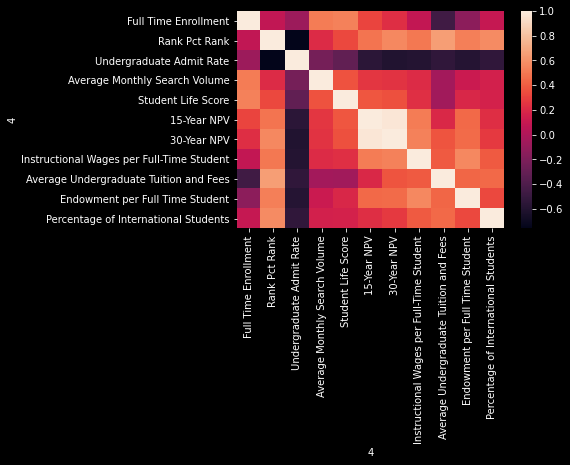

In [555]:
sns.heatmap(df_norm.corr())
plt.show()

Now that we have prepared our data, we can perform a cluster analysis.  We choose to perform agglomerative clustering.  To visualize the clustering process we first generate a dendrogram.

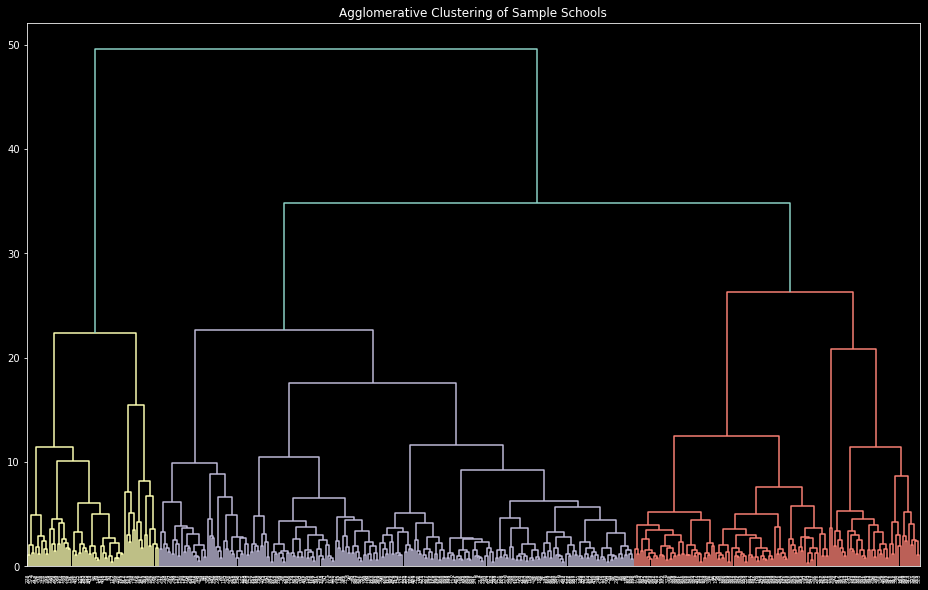

In [556]:
plt.figure(figsize = (16, 10))
dend = dendrogram(linkage(df_norm, method = 'ward'))
plt.title("Agglomerative Clustering of Sample Schools")
plt.show()

The dendrogram suggests that three clusters would be an appropriate choice.  Let's proceed under this choice to label our samples so that we can compare this method of classifying schools with Galloway's method.

In [557]:
n_clust = 3

agglclst = AgglomerativeClustering(n_clusters = n_clust,
                                   linkage = 'ward',
                                   affinity = 'euclidean')
class_results = pd.DataFrame(agglclst.fit_predict(df_norm))

In [558]:
df_merged = df.merge(class_results, 
                          how = 'inner', 
                          left_index = True, 
                          right_index = True)

df_merged.rename(columns = {0 : "Cluster"},
                 inplace = True)

We also attempt to visualize the data set in the plane using a t-SNE algorithm.

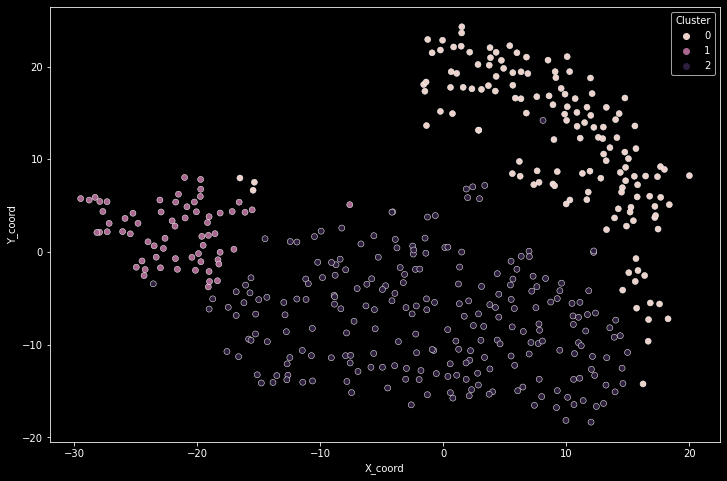

In [559]:
tsne = TSNE()
df_flat = pd.DataFrame(tsne.fit_transform(df_norm))

df_scatterplot = df_flat.merge(class_results,
                               how = 'inner',
                               left_index = True,
                               right_index = True)

df_scatterplot.rename({'0_x' : 'X_coord', 1 : 'Y_coord', '0_y' : 'Cluster'}, 
                      axis = 'columns',
                      inplace = True)

plt.figure(figsize = (12, 8))
sns.scatterplot(data = df_scatterplot,
                x = 'X_coord',
                y = 'Y_coord',
                hue = 'Cluster')

plt.show()

In order to compare the two classification systems, we plot the distribution of each of Galloway's categories within each cluster.

In [560]:
df_orig.reset_index(inplace = True)
df_merged['Prof G'] = df_orig['Prof G Categorization']

df_compare = df_merged.loc[:, ['Cluster', 'Prof G']]
profGclasses = ['Struggle', 'Challenged', 'Survive', 'Thrive']
df_compare.reset_index(inplace = True)

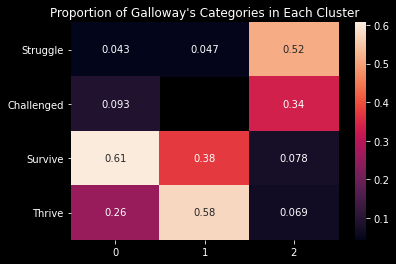

In [561]:
compare_array = []

for label in profGclasses:
    
    in_class_series = df_compare[df_compare['Prof G'] == label]['Cluster'].value_counts(sort = False)
    total_series = df_compare['Cluster'].value_counts(sort = False)
    ratio_series = in_class_series / total_series
    compare_array.append(list(ratio_series.values))


compare_df = pd.DataFrame(np.array(compare_array))
compare_df.fillna(0, inplace = True)

sns.heatmap(compare_array, yticklabels = profGclasses, annot = True)
plt.title("Proportion of Galloway's Categories in Each Cluster")
plt.show()

We do see some correlation between Galloway's categories and our clusters.  Generally, our clusters do not tend to fit in any one of Galloway's categories, but they do tend to fit into one of the Thrive/Survive (Strong) or the Challenged/Struggle (Weak) categories.  However, even relaxing Galloway's categories in this way still leaves significant residuals between the categories, so that the relationship is at best moderately correlated.  In particular, we note that Clusters 1 and 2 appear to be significantly different assuming Galloway's classification.

Let's get a better sense of what the clusters we found mean independent of Galloway's categories by displaying summary statistics in each cluster.

In [562]:
display(df_merged.groupby(['Cluster']).mean())
display(df_merged.groupby(['Cluster']).std())

,Full Time Enrollment,Rank Pct Rank,Undergraduate Admit Rate,Average Monthly Search Volume,Student Life Score,15-Year NPV,30-Year NPV,Instructional Wages per Full-Time Student,Average Undergraduate Tuition and Fees,Endowment per Full Time Student,Percentage of International Students
Cluster,,,,,,,,,,,
0,13434.135714,0.500286,60.357143,60423.642857,4.247000,292928.571429,789950.000000,11538.457143,32924.092857,123567.435714,6.714286
1,11173.171875,0.540625,57.203125,53346.875000,4.230781,300390.625000,817906.250000,10559.265625,37221.812500,156681.296875,6.890625
2,9000.324675,0.497273,58.926407,53055.238095,4.095022,295532.467532,805454.545455,11019.086580,37044.727273,159504.870130,5.731602


,Full Time Enrollment,Rank Pct Rank,Undergraduate Admit Rate,Average Monthly Search Volume,Student Life Score,15-Year NPV,30-Year NPV,Instructional Wages per Full-Time Student,Average Undergraduate Tuition and Fees,Endowment per Full Time Student,Percentage of International Students
Cluster,,,,,,,,,,,
0,13286.666120,0.282631,22.309488,97070.096598,0.649288,71749.027302,164885.280590,8102.216260,14112.100601,292864.689733,6.076592
1,12311.640814,0.291384,23.555527,64255.042341,0.650131,98918.535857,225127.104751,5812.913829,14449.175839,237714.023718,6.208333
2,10208.537558,0.289692,23.716601,82265.384970,0.713975,86635.807099,198515.022679,8191.989179,14046.149056,277706.590563,5.070528


In order to determine which features are important in distinguishing the clusters, we perform a Bonferroni pairwise t-test.  We can adjust the significance $\alpha$ to see for at what significance each cluster is distinguished by at least one feature.  This gives a p-value like measure of how separated the clusters are.  

In [563]:
alpha = 0.28

print("Significant Differences Between Features:")

for col in df_merged.select_dtypes(include = 'float64').columns:
    for i in range(n_clust):
        for j in range(i):
            u_score, p_value = mannwhitneyu(df_merged[df_merged['Cluster'] == i][col],
                                                df_merged[df_merged['Cluster'] == j][col])
            if p_value <= alpha / (1/2 * n_clust * (n_clust - 1)):
                print("Clusters", i, "and", j, ": ", col)

Significant Differences Between Features:
Clusters 1 and 0 :  Full Time Enrollment
Clusters 2 and 0 :  Full Time Enrollment
Clusters 2 and 0 :  Student Life Score
Clusters 2 and 0 :  Instructional Wages per Full-Time Student
Clusters 1 and 0 :  Average Undergraduate Tuition and Fees
Clusters 2 and 0 :  Average Undergraduate Tuition and Fees
Clusters 1 and 0 :  Endowment per Full Time Student
Clusters 2 and 0 :  Endowment per Full Time Student
Clusters 2 and 0 :  Percentage of International Students


When we do so in the above code, we find that all clusters are pairwise distinct with respect to some feature at significance $\alpha = 0.29$.  This level of significance seems high to the point where it is doubtful that the test is giving reliable results.

The next change occurs in the range $\alpha \in (0.08, 0.29)$, at which point Cluster 0 is distinct from clusters 1 and 2, but Clusters 1 and 2 cannot be distinguished.  At the lower values in this range, Clusters 0 and 1 are distinguished only by Average Undergraduate Tuition and Fees.

Finally, at lower significances, we find only that Clusters 0 and 2 are distinguishable, with the distinguishing features being the Endowment per Full Time Student ($\alpha = 0.05$), Average Undergraduate Tuition and Fees ($\alpha = 0.02$), and Full Time Enrollment ($\alpha = 0.002$).

To compare above, Galloway's classification would rate schools in Cluster 2 as distinct (and financially more imperiled) than schools in either Clusters 0 and 1.  While we do find differences between Clusters 0 and 2 at reasonable significances, we cannot show any difference in any features between Clusters 1 and 2 even at fairly liberal significance levels as high as $\alpha = 0.28$, which seems inconsistent with Galloway's categorization.

### Conclusion
***
We cleaned the raw data in Galloway's data set and created a classification using agglomerative clustering.  We found that the resulting clusters were inconsistent with the categories developed by Galloway.  Since agglomerative clustering groups data points by similarity in feature values, we conclude one of two things: 

(1)  The features selected are sufficient to decide financial health in higher education, and Galloway's categories do not respect the general principle that data points with similar observations ought to be similarly classified.  Hence Galloway's classification is not valid.
    
(2)  The features selected in this data set are not sufficient to determine financial health of colleges and universities.

I suspect that (2) is closer to the truth, but it is difficult to test the validity of any of these classifications without data that more directly addresses the question, in particular data about schools that have been known to succeed or fail financially.

### Appendix

***

For reference, we include a list of the colleges and universities included in our data set grouped by cluster, as well as a breakdown of the number of schools per state in each cluster.

In [564]:
for clust in range(n_clust):
    print()
    print("CLUSTER", clust)
    print(list(df_merged[df_merged['Cluster'] == clust]['Institution Name']))


CLUSTER 0
['Agnes Scott College', 'Arizona State University-Tempe', 'Bellarmine University', 'Berea College', 'Binghamton University', 'Birmingham Southern College', 'Brandeis University', 'Carleton College', 'Chapman University', 'College of Saint Benedict', 'Concordia University-Wisconsin', 'Drake University', 'Eckerd College', 'Elizabethtown College', 'Elon University', 'Florida International University', 'Franklin College', 'George Fox University', 'Georgetown University', 'Guilford College', 'Hollins University', 'Howard University', 'Illinois College', 'Illinois Institute of Technology', 'Indiana University-Bloomington', 'Indiana University-Purdue University-Indianapolis', 'Lehigh University', 'Lesley University', 'Lewis & Clark College', 'Maryville University of Saint Louis', 'Miami University-Oxford', 'Middlebury College', 'Millsaps College', 'Montclair State University', 'Moravian College', 'Morehouse College', 'Mount Holyoke College', 'Muhlenberg College', 'New York Universi

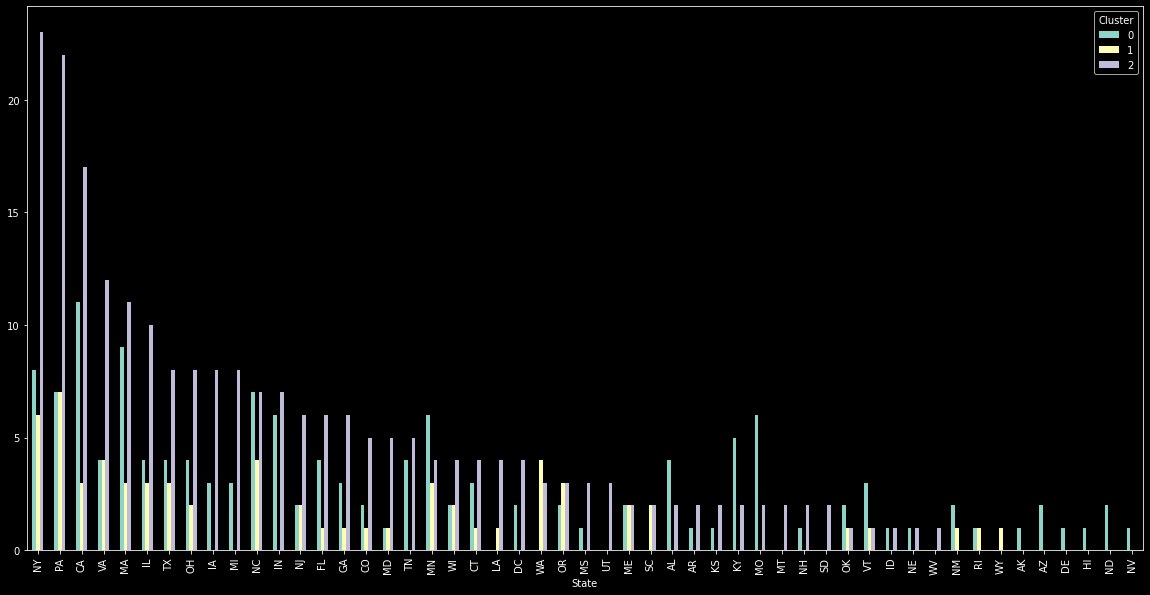

In [565]:
pd.pivot_table(data = df_merged, 
               index = "State", 
               columns = "Cluster", 
               values = "Institution Name", 
               aggfunc = 'count').fillna(0).astype('int')\
               .sort_values([2, 1], ascending = False)\
               .plot(kind = 'bar', figsize = (20, 10))
plt.show()